In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
import random
import time
from tqdm import tqdm

import gym_Snake

from keras import layers,Model,optimizers,losses
import tensorflow as tf

In [4]:
env_reward = {"REWARD_TARGET":1,
    "REWARD_COLLISION":-1,
    "REWARD_TOWARD":1/10,
    "REWARD_AWAY":-1/10}

In [64]:
env = gym.make('Snake-v0', 
               player='player', 
               shape='Normal', 
               state_mode='matrix', 
               reward_mode = 'extended', 
               width=10, 
               height=10, 
               solid_border=True,
               rewards=env_reward)
print(env.observation_space)
print(env.action_space)

Discrete(100)
Discrete(3)


In [79]:
n = env.observation_space.n
x = ((int(np.sqrt(n)),int(np.sqrt(n)),1,))
x

(10, 10, 1)

Maybe input is too small for convolution. Trying by playing on a 16x16 -> scaled up to 64x64

In [16]:
test = np.array([[1,2],[3,4]])
test

array([[1, 2],
       [3, 4]])

In [48]:
test2 = test.repeat(4,axis=0).repeat(4,axis=1)
test2

array([[1, 1, 1, 1, 2, 2, 2, 2],
       [1, 1, 1, 1, 2, 2, 2, 2],
       [1, 1, 1, 1, 2, 2, 2, 2],
       [1, 1, 1, 1, 2, 2, 2, 2],
       [3, 3, 3, 3, 4, 4, 4, 4],
       [3, 3, 3, 3, 4, 4, 4, 4],
       [3, 3, 3, 3, 4, 4, 4, 4],
       [3, 3, 3, 3, 4, 4, 4, 4]])

In [56]:
#input_shape = (obs.shape)

input_matrix = (64,64,1,)

number_of_action = 3


# Classic 3L CNN into 2 dense output layer serving as Deep Q Network
# 3 conv2D layer into maxpooling into flatten into 2 denses layers

# Can remove the max pooling maybe, and change last layer softmax -> linear if simpler needed
# Archi based on different readings // assumed similar difficulties as MNIST personal implementation

def create_Q_network():

    inputs = layers.Input(shape=input_matrix)

    # CNN layers
    layer1 = layers.Conv2D(32, kernel_size=(3, 3),activation="relu")(inputs)
    layer2 = layers.Conv2D(64, kernel_size=(3, 3),activation="relu")(layer1)
    layer3 = layers.Conv2D(128, kernel_size=(3, 3),activation="relu")(layer2)

    # Max Pooling which can probably be removed 
    #layer4 = layers.MaxPooling2D(pool_size=(4,4))(layer3)

    # Flatten 
    layer5 = layers.Flatten()(layer3)

    # Dense layer to predict the action
    layer6 = layers.Dense(256,activation="relu")(layer5)
    action = layers.Dense(number_of_action,activation="linear")(layer6)

    return Model(inputs=inputs,outputs=action)

In [80]:
input_matrix

(64, 64, 1)

In [5]:
#input_shape = (obs.shape)

input_matrix = (20,20,1,)

number_of_action = 3


# Classic 3L CNN into 2 dense output layer serving as Deep Q Network
# 3 conv2D layer into maxpooling into flatten into 2 denses layers

# Can remove the max pooling maybe, and change last layer softmax -> linear if simpler needed
# Archi based on different readings // assumed similar difficulties as MNIST personal implementation

def create_small_Q_network(input_matrix,number_of_action):

    inputs = layers.Input(shape=input_matrix)

    # CNN layers
    layer1 = layers.Conv2D(32, kernel_size=(3, 3),activation="relu")(inputs)
    layer2 = layers.Conv2D(64, kernel_size=(3, 3),activation="relu")(layer1)
    #layer3 = layers.Conv2D(128, kernel_size=(3, 3),activation="relu")(layer2)

    # Max Pooling which can probably be removed 
    #layer4 = layers.MaxPooling2D(pool_size=(2,2))(layer3)

    # Flatten 
    layer5 = layers.Flatten()(layer2)

    # Dense layer to predict the action
    layer6 = layers.Dense(128,activation="relu")(layer5)
    action = layers.Dense(number_of_action,activation="softmax")(layer6)

    return Model(inputs=inputs,outputs=action)


In [6]:
model = create_small_Q_network()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 20, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 18, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,116,483
Trainable params: 2,116,483
Non-trainable params: 0
___________________________________________________

2022-05-18 09:52:02.838725: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-18 09:52:02.838867: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-18 09:52:02.840426: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
model_target = create_small_Q_network()

model_target.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 20, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 2,116,483
Trainable params: 2,116,483
Non-trainable params: 0
_________________________________________________

In [9]:
loss_function = losses.Huber()
optimizer = optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

def play_epoch(env,replay_buffer,frame_number,epoch_number,Q_update,target_update, discount = 0.99,max_steps_per_epoch = 1000,
epsilon_min = 0.0002,explo_games = 5000,epsilon_games = 15000,render = False):

    state = env.reset().repeat(2,axis=0).repeat(2,axis=1)
    
    episode_reward = 0
    
    done = False

    step_counter = 0
    random_action_counter = 0

    #################################
    ## Change to modify the model training
    
    # How many frame to recover from the replay buffer
    batch_size = 64
    # Train the model after 4 actions
    update_Q_network = 4
    # How often to update the target network
    update_target_network = 10000
    # Replay buffer size
    max_memory_length = 1000000

    # Decay the epsilon only after each new games, rather than each frames of the games, probably not too relevant

    ###############################
    # Epsilon decay

    # Decay probability of taking random action
    epsilon = 1. - (epoch_number / epsilon_games)
    epsilon = max(epsilon, epsilon_min)

    while not done and step_counter < max_steps_per_epoch:
        
        step_counter += 1
        frame_number += 1

        ###############################
        # Show
        
        if render: env.render()

        ###############################
        # Select Action

        # Use epsilon greedy for exploration, 
        # also in the beginning for "epsilon_random_frames" always random
        if epoch_number < explo_games or epsilon > random.random():
            # Take random action
            action = np.random.choice(number_of_action)
            random_action_counter += 1
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        

        ###############################
        # Act in the env

        state_next, reward, done, _ = env.step(action)
        state_next = state_next.repeat(2,axis=0).repeat(2,axis=1)

        ###############################
        # Store reward for that run

        episode_reward += reward    

        ###############################
        # Slow render
        if render: time.sleep(0.5)

        ###############################
        # Save actions and states in replay buffer
        
        replay_buffer.append([state,action,reward,state_next,done])
 
        state = state_next

        ###############################
        # Update the Q-Network

        # Only once every 4 frames (good tradeoff between speed and efficiency of training)
        # and only when the buffer is at least 32 (the size of the batch)
        
        # Update every fourth frame and once batch size is over 32
        if frame_number % update_Q_network == 0 and len(replay_buffer) > batch_size:

            Q_update += 1
            # Get indices of samples for replay buffers
            samples = random.sample(replay_buffer,batch_size)

            # Sample from replay buffer
            action_sample = []
            state_sample = []
            state_next_sample = []
            rewards_sample = []
            done_sample = []

            for sample in samples:
                s, a, r, s_t, d = sample
                action_sample.append(a)
                state_sample.append(s)
                state_next_sample.append(s_t)
                rewards_sample.append(r)
                done_sample.append(float(d))

            state_sample = np.array(state_sample)
            state_next_sample = np.array(state_next_sample)
            done_sample = tf.convert_to_tensor(done_sample)

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + discount * tf.reduce_max(future_rewards, axis=1)

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, number_of_action)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        ###############################
        # Update the target-Network

        if frame_number % update_target_network == 0:
            
            target_update += 1
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())

        ###############################
        # Delete the 1'000 oldest replays from buffer history when bigger than allowed 

        if len(replay_buffer) > max_memory_length:
            
            del replay_buffer[:1000]
        

    return episode_reward,frame_number,epsilon,random_action_counter,Q_update,target_update

In [23]:

# Experience replay buffers
replay_buffer = []


episode_reward_history = []
episode_epsilon_history = []
episode_random_action_history = []
# Using huber loss for stability
loss_function = losses.Huber()

# number of epoch
#nb_iterations = 50000
nb_iterations = 30000
#nb_iterations = 10

frame_number = 0

Q_update = 0
target_update = 0

for i in tqdm(range(nb_iterations)):

    r_episode,frame_number,epsilon,random_action,Q_update,target_update = play_epoch(env=env,replay_buffer=replay_buffer,frame_number=frame_number,
    epoch_number=i,Q_update=Q_update,target_update=target_update)
    episode_reward_history.append(r_episode)
    episode_epsilon_history.append(epsilon)
    episode_random_action_history.append(random_action)

    if i % 1000 == 0:

        print("Epoch {}, len of replay buffer {}, current epsilon {}, number of played frames {}".format(i,len(replay_buffer),epsilon,frame_number))
        print("Number of Q_network update {},number of target update {}".format(Q_update,target_update))
        print("Reward over the last 50 rounds{}".format(np.array(episode_reward_history[-50:]).mean()))
model.save("../Tests/networks/small_q_network")
model_target.save("../Tests/networks/small_target_network")


  0%|          | 5/30000 [00:00<20:16, 24.65it/s]

Epoch 0, len of replay buffer 19, current epsilon 1.0, number of played frames 19
Number of Q_network update 0,number of target update 0
Reward over the last 50 rounds-1.6


  3%|▎         | 1001/30000 [10:50<5:50:55,  1.38it/s]

Epoch 1000, len of replay buffer 13776, current epsilon 0.9333333333333333, number of played frames 13776
Number of Q_network update 3428,number of target update 1
Reward over the last 50 rounds-1.044


  7%|▋         | 2001/30000 [21:20<3:49:39,  2.03it/s] 

Epoch 2000, len of replay buffer 27353, current epsilon 0.8666666666666667, number of played frames 27353
Number of Q_network update 6822,number of target update 2
Reward over the last 50 rounds-0.9739999999999999


 10%|█         | 3001/30000 [31:47<3:31:26,  2.13it/s] 

Epoch 3000, len of replay buffer 40780, current epsilon 0.8, number of played frames 40780
Number of Q_network update 10179,number of target update 4
Reward over the last 50 rounds-1.026


 13%|█▎        | 4002/30000 [42:32<2:48:48,  2.57it/s] 

Epoch 4000, len of replay buffer 54452, current epsilon 0.7333333333333334, number of played frames 54452
Number of Q_network update 13597,number of target update 5
Reward over the last 50 rounds-1.078


 17%|█▋        | 5001/30000 [53:09<4:50:08,  1.44it/s]

Epoch 5000, len of replay buffer 67952, current epsilon 0.6666666666666667, number of played frames 67952
Number of Q_network update 16972,number of target update 6
Reward over the last 50 rounds-0.9220000000000002


 20%|██        | 6001/30000 [1:06:49<3:13:49,  2.06it/s] 

Epoch 6000, len of replay buffer 84678, current epsilon 0.6, number of played frames 84678
Number of Q_network update 21153,number of target update 8
Reward over the last 50 rounds-0.24799999999999994


 23%|██▎       | 7001/30000 [1:21:12<3:10:32,  2.01it/s] 

Epoch 7000, len of replay buffer 101642, current epsilon 0.5333333333333333, number of played frames 101642
Number of Q_network update 25394,number of target update 10
Reward over the last 50 rounds0.13800000000000004


 27%|██▋       | 8001/30000 [1:36:29<4:47:05,  1.28it/s] 

Epoch 8000, len of replay buffer 119273, current epsilon 0.4666666666666667, number of played frames 119273
Number of Q_network update 29802,number of target update 11
Reward over the last 50 rounds0.4340000000000001


 30%|███       | 9001/30000 [1:52:31<10:28:30,  1.80s/it]

Epoch 9000, len of replay buffer 137439, current epsilon 0.4, number of played frames 137439
Number of Q_network update 34343,number of target update 13
Reward over the last 50 rounds0.7140000000000002


 33%|███▎      | 10001/30000 [2:07:19<6:57:47,  1.25s/it]

Epoch 10000, len of replay buffer 155829, current epsilon 0.33333333333333337, number of played frames 155829
Number of Q_network update 38941,number of target update 15
Reward over the last 50 rounds1.0859999999999999


 37%|███▋      | 11001/30000 [2:23:43<5:48:08,  1.10s/it] 

Epoch 11000, len of replay buffer 176229, current epsilon 0.2666666666666667, number of played frames 176229
Number of Q_network update 44041,number of target update 17
Reward over the last 50 rounds1.5980000000000003


 40%|████      | 12001/30000 [2:41:31<5:51:56,  1.17s/it] 

Epoch 12000, len of replay buffer 198457, current epsilon 0.19999999999999996, number of played frames 198457
Number of Q_network update 49598,number of target update 19
Reward over the last 50 rounds2.6060000000000003


 43%|████▎     | 13002/30000 [3:02:09<3:51:16,  1.22it/s] 

Epoch 13000, len of replay buffer 223914, current epsilon 0.1333333333333333, number of played frames 223914
Number of Q_network update 55962,number of target update 22
Reward over the last 50 rounds3.0


 47%|████▋     | 14001/30000 [3:27:51<7:40:48,  1.73s/it] 

Epoch 14000, len of replay buffer 255720, current epsilon 0.06666666666666665, number of played frames 255720
Number of Q_network update 63914,number of target update 25
Reward over the last 50 rounds4.451999999999998


 50%|█████     | 15001/30000 [4:11:32<52:17:37, 12.55s/it] 

Epoch 15000, len of replay buffer 309691, current epsilon 0.0002, number of played frames 309691
Number of Q_network update 77406,number of target update 30
Reward over the last 50 rounds6.907999999999996


 53%|█████▎    | 16001/30000 [6:26:21<14:49:42,  3.81s/it] 

Epoch 16000, len of replay buffer 476616, current epsilon 0.0002, number of played frames 476616
Number of Q_network update 119138,number of target update 47
Reward over the last 50 rounds7.321999999999997


 57%|█████▋    | 17001/30000 [8:39:41<15:06:10,  4.18s/it] 

Epoch 17000, len of replay buffer 635937, current epsilon 0.0002, number of played frames 635937
Number of Q_network update 158968,number of target update 63
Reward over the last 50 rounds8.323999999999996


 60%|██████    | 18001/30000 [10:49:07<38:41:57, 11.61s/it] 

Epoch 18000, len of replay buffer 787586, current epsilon 0.0002, number of played frames 787586
Number of Q_network update 196880,number of target update 78
Reward over the last 50 rounds9.943999999999994


 63%|██████▎   | 19001/30000 [12:48:05<20:18:11,  6.65s/it]

Epoch 19000, len of replay buffer 925991, current epsilon 0.0002, number of played frames 925991
Number of Q_network update 231481,number of target update 92
Reward over the last 50 rounds10.079999999999995


 67%|██████▋   | 20001/30000 [15:01:02<18:29:34,  6.66s/it]

Epoch 20000, len of replay buffer 999379, current epsilon 0.0002, number of played frames 1080379
Number of Q_network update 270078,number of target update 108
Reward over the last 50 rounds11.083999999999994


 70%|███████   | 21001/30000 [17:14:37<12:49:24,  5.13s/it]

Epoch 21000, len of replay buffer 999691, current epsilon 0.0002, number of played frames 1237691
Number of Q_network update 309406,number of target update 123
Reward over the last 50 rounds9.431999999999995


 73%|███████▎  | 22001/30000 [19:37:17<43:38:28, 19.64s/it]

Epoch 22000, len of replay buffer 999222, current epsilon 0.0002, number of played frames 1405222
Number of Q_network update 351289,number of target update 140
Reward over the last 50 rounds10.745999999999995


 77%|███████▋  | 23001/30000 [21:50:50<8:51:17,  4.55s/it] 

Epoch 23000, len of replay buffer 999136, current epsilon 0.0002, number of played frames 1563136
Number of Q_network update 390768,number of target update 156
Reward over the last 50 rounds10.729999999999995


 80%|████████  | 24001/30000 [23:52:52<30:20:45, 18.21s/it]

Epoch 24000, len of replay buffer 999220, current epsilon 0.0002, number of played frames 1706220
Number of Q_network update 426539,number of target update 170
Reward over the last 50 rounds10.009999999999996


 83%|████████▎ | 25001/30000 [26:02:48<12:32:28,  9.03s/it]

Epoch 25000, len of replay buffer 999940, current epsilon 0.0002, number of played frames 1858940
Number of Q_network update 464719,number of target update 185
Reward over the last 50 rounds12.335999999999995


 87%|████████▋ | 26001/30000 [28:12:17<5:55:46,  5.34s/it] 

Epoch 26000, len of replay buffer 999495, current epsilon 0.0002, number of played frames 2010495
Number of Q_network update 502607,number of target update 201
Reward over the last 50 rounds11.355999999999996


 90%|█████████ | 27001/30000 [30:04:53<7:31:44,  9.04s/it] 

Epoch 27000, len of replay buffer 999642, current epsilon 0.0002, number of played frames 2142642
Number of Q_network update 535644,number of target update 214
Reward over the last 50 rounds12.249999999999998


 93%|█████████▎| 28001/30000 [32:10:20<2:10:28,  3.92s/it] 

Epoch 28000, len of replay buffer 999870, current epsilon 0.0002, number of played frames 2289870
Number of Q_network update 572451,number of target update 228
Reward over the last 50 rounds12.325999999999999


 97%|█████████▋| 29001/30000 [34:18:10<1:13:58,  4.44s/it] 

Epoch 29000, len of replay buffer 999967, current epsilon 0.0002, number of played frames 2439967
Number of Q_network update 609975,number of target update 243
Reward over the last 50 rounds12.526


100%|██████████| 30000/30000 [36:26:13<00:00,  4.37s/it]  


INFO:tensorflow:Assets written to: ../Tests/networks/small_q_network/assets
INFO:tensorflow:Assets written to: ../Tests/networks/small_target_network/assets


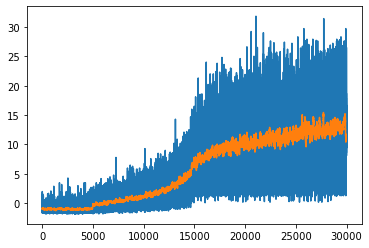

In [24]:
N = 50
plt.plot(range(len(episode_reward_history)), episode_reward_history)
plt.plot(np.convolve(np.array(episode_reward_history), np.ones(N)/N, mode='valid'))

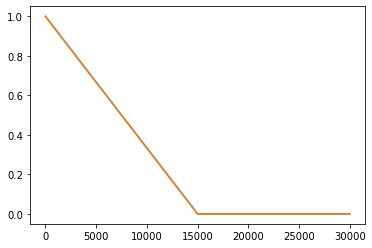

In [25]:
N = 50
plt.plot(range(len(episode_epsilon_history)), episode_epsilon_history)
plt.plot(np.convolve(np.array(episode_epsilon_history), np.ones(N)/N, mode='valid'))

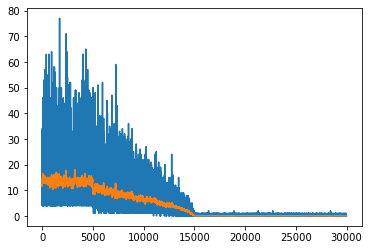

In [26]:
N = 50
plt.plot(range(len(episode_random_action_history)), episode_random_action_history)
plt.plot(np.convolve(np.array(episode_random_action_history), np.ones(N)/N, mode='valid'))

In [83]:
input_matrix = (64,64,1,)

number_of_action = 3
model = tf.keras.models.load_model("../../../Tests/networks/10x_classic_30k_smallQ", compile=False)

In [84]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 20, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 18, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,116,483
Trainable params: 2,116,483
Non-trainable params: 0
___________________________________________________

In [85]:
test = "test"
model.save("./{}_smallQ".format(test))

2022-05-20 22:29:44.519660: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./test_smallQ/assets


In [9]:
env.action_space

Discrete(3)

In [9]:
state = env.reset().repeat(2,axis=0).repeat(2,axis=1)
state

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 8, 8, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 8, 8, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0,

In [10]:
state_tensor = tf.convert_to_tensor(state)
state_tensor = tf.expand_dims(state_tensor, 0)
action_probs = model(state_tensor, training=False)
action = tf.argmax(action_probs[0]).numpy()
action

1

In [11]:
state_next, reward, done, _ = env.step(action)
state_next = state_next.repeat(2,axis=0).repeat(2,axis=1)
state_next

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0,

In [57]:
env_shuriken = gym.make('Snake-v0', 
               player='computer', 
               shape='Shuriken', 
               state_mode='matrix', 
               reward_mode = 'extended', 
               width=10, 
               height=10, 
               solid_border=True,
               rewards=env_reward)
print(env_shuriken.observation_space)
print(env_shuriken.action_space)

Discrete(100)
Discrete(3)


In [58]:
state = env_shuriken.reset()
state

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 2, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 0, 8, 3, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [39]:
env_doubleh = gym.make('Snake-v0', 
               player='player', 
               shape='Double_h', 
               state_mode='matrix', 
               reward_mode = 'extended', 
               width=10, 
               height=10, 
               solid_border=True,
               rewards=env_reward)
print(env_doubleh.observation_space)
print(env_doubleh.action_space)

Discrete(100)
Discrete(3)


In [40]:
state = env_doubleh.reset().repeat(2,axis=0).repeat(2,axis=1)
state

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0,

In [86]:
env = gym.make('Snake-v0', 
               player='player', 
               shape='Classic', 
               state_mode='matrix', 
               reward_mode = 'extended', 
               width=10, 
               height=10, 
               solid_border=True,
               rewards=env_reward)
#print(env_doubleh.observation_space)
#print(env_doubleh.action_space)

In [87]:
def play_game(env,model,max_steps_per_epoch = 1000,render = False):

    
    state = env.reset().repeat(2,axis=0).repeat(2,axis=1)
    #state = env.reset()
    episode_reward = 0
    
    done = False
    step_counter = 0
    target_eaten = 0
    
    
    while not done and step_counter < max_steps_per_epoch:
        
        step_counter += 1
        
        ###############################
        # Show
        
        if render: env.render()

        ###############################
        # Select Action

        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = model(state_tensor, training=False)
        # Take best action
        action = tf.argmax(action_probs[0]).numpy()

        ###############################
        # Act in the env

        state_next, reward, done, _ = env.step(action)
        state_next = state_next.repeat(2,axis=0).repeat(2,axis=1)
        ###############################
        # Store reward for that run

        episode_reward += reward  

        if reward == 1:
            target_eaten += 1  

        ###############################
        # Slow render

        if render: time.sleep(0.5)

        ###############################
        # Update state

        state = state_next


    return episode_reward,target_eaten,step_counter

In [88]:
reward_history = []
target_eaten_history = []
frame_survived_history = []

nb_game = 50


for i in tqdm(range(nb_game)):

    r_episode,target_eaten,frame_survived = play_game(env=env,model= model,render=False)
    reward_history.append(r_episode)
    target_eaten_history.append(target_eaten)
    frame_survived_history.append(frame_survived)

   


100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


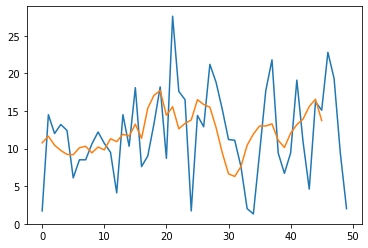

In [89]:
N = 5
plt.plot(range(len(reward_history)), reward_history)
plt.plot(np.convolve(np.array(reward_history), np.ones(N)/N, mode='valid'))

In [6]:
classic = pd.read_csv("final_10x_Classic_50000_smallQ.csv")
classic

,Unnamed: 0,0
0,0,-0.6
1,1,-2.0
2,2,-1.4
3,3,-1.6
4,4,-1.2
...,...,...
49995,49995,24.0
49996,49996,33.4
49997,49997,24.0
49998,49998,28.0


In [7]:
double_v = pd.read_csv("final_10x_Double_v_50000_smallQ.csv")
double_v

,Unnamed: 0,0
0,0,-1.0
1,1,-0.4
2,2,-1.0
3,3,-1.0
4,4,-1.4
...,...,...
49995,49995,9.4
49996,49996,0.4
49997,49997,19.8
49998,49998,1.6


In [8]:
shuriken = pd.read_csv("final_10x_Shuriken_50000_smallQ.csv")
shuriken

,Unnamed: 0,0
0,0,-1.6
1,1,0.4
2,2,-1.4
3,3,-1.8
4,4,-1.4
...,...,...
49995,49995,5.2
49996,49996,5.0
49997,49997,3.6
49998,49998,9.2


In [9]:
N = 200

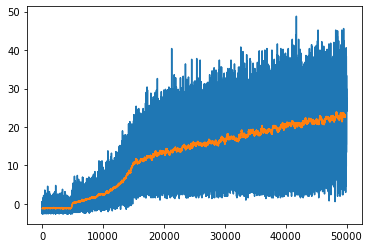

In [10]:
plt.plot(range(len(classic["0"])), classic["0"])
plt.plot(np.convolve(np.array(classic["0"]), np.ones(N)/N, mode='valid'))

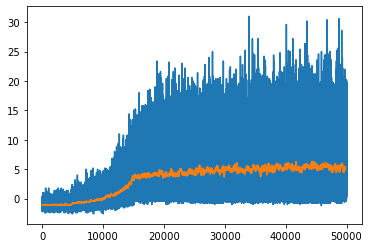

In [11]:
plt.plot(range(len(double_v["0"])), double_v["0"])
plt.plot(np.convolve(np.array(double_v["0"]), np.ones(N)/N, mode='valid'))

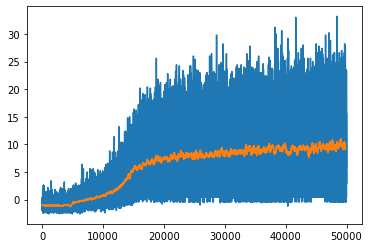

In [12]:
plt.plot(range(len(shuriken["0"])), shuriken["0"])
plt.plot(np.convolve(np.array(shuriken["0"]), np.ones(N)/N, mode='valid'))

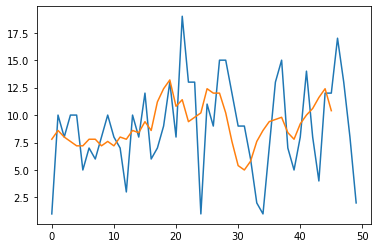

In [90]:
N = 5
plt.plot(range(len(target_eaten_history)), target_eaten_history)
plt.plot(np.convolve(np.array(target_eaten_history), np.ones(N)/N, mode='valid'))

In [91]:
print("Over 50 optimised runs, the snake was able to eat on average {} targets per run, with an optimal run where it was able to eat {} target in a single run".format(np.mean(target_eaten_history),np.max(target_eaten_history)))

Over 50 optimised runs, the snake was able to eat on average 8.92 targets per run, with an optimal run where it was able to eat 19 target in a single run


In [56]:
play_game(env=env_big,model=model,render=True)

error: font not initialized

Discrete(100)
Discrete(3)
